### Content

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community


In [1]:
import collections
import os
import random
from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image, ImageOps, ImageEnhance
import pydicom as dicom

In [2]:
database_path = '../../data/raw/nih-chest-xrays/'

data = pd.read_csv(os.path.join(database_path, 'Data_Entry_2017.csv'))
data

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0          2749                        0.143  0.143          NaN  
1          2729                        0.143  0.143          NaN  
2          2048                        0.168  0.168          NaN  
3          2048                        0.171  0.171          NaN  
4          2991                        0.143  0.143          NaN  
...         ...                          ...    ...          ...  
112115     2500                        0.168  0.168          NaN  
112116     2500                        0.168  0.168          NaN  
112117     2500                        0.168  0.168          NaN  
112118     2500                        0.168  0.168          NaN  
112119     2500                        0.171  0.171          NaN  

[112120 rows x 12 columns]

In [3]:
data.describe().transpose()

count          mean          std       min  \
Follow-up #                  112120.0      8.573751    15.406320     0.000   
Patient ID                   112120.0  14346.381743  8403.876972     1.000   
Patient Age                  112120.0     46.901463    16.839923     1.000   
OriginalImage[Width          112120.0   2646.078844   341.246429  1143.000   
Height]                      112120.0   2486.438842   401.268227   966.000   
OriginalImagePixelSpacing[x  112120.0      0.155649     0.016174     0.115   
y]                           112120.0      0.155649     0.016174     0.115   
Unnamed: 11                       0.0           NaN          NaN       NaN   

                                  25%        50%        75%         max  
Follow-up #                     0.000      3.000     10.000    183.0000  
Patient ID                   7310.750  13993.000  20673.000  30805.0000  
Patient Age                    35.000     49.000     59.000    414.0000  
OriginalImage[Width          2500.000   2518.000   2992.000   3827.0000  
Height]                      2048.000   2544.000   2991.000   4715.0000  
OriginalImagePixelSpacing[x     0.143      0.143      0.168      0.1988  
y]                              0.143      0.143      0.168      0.1988  
Unnamed: 11                       NaN        NaN        NaN         NaN

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
data['Finding Labels'].value_counts()

No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: Finding Labels, Length: 836, dtype: int64

In [6]:
data['Patient ID'].value_counts()

10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
13617      1
13610      1
13609      1
13607      1
30805      1
Name: Patient ID, Length: 30805, dtype: int64

In [7]:
data['Image Index'].value_counts()

00000001_000.png    1
00018360_005.png    1
00018360_016.png    1
00018360_015.png    1
00018360_014.png    1
                   ..
00009863_014.png    1
00009863_013.png    1
00009863_012.png    1
00009863_011.png    1
00030805_000.png    1
Name: Image Index, Length: 112120, dtype: int64

In [8]:
data['Patient Gender'].value_counts()

M    63340
F    48780
Name: Patient Gender, dtype: int64

In [9]:
data['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

In [20]:
all_labels = []
for val in data['Finding Labels']:
    all_labels += val.split('|')
counter = collections.Counter(all_labels)
counter

Counter({'Cardiomegaly': 2776,
         'Emphysema': 2516,
         'Effusion': 13317,
         'No Finding': 60361,
         'Hernia': 227,
         'Infiltration': 19894,
         'Mass': 5782,
         'Nodule': 6331,
         'Atelectasis': 11559,
         'Pneumothorax': 5302,
         'Pleural_Thickening': 3385,
         'Pneumonia': 1431,
         'Fibrosis': 1686,
         'Edema': 2303,
         'Consolidation': 4667})

In [22]:
labels_freq = pd.DataFrame([{"Finding Labels": k, "Frequency": v} for k,v in counter.items()])
labels_freq['%'] = labels_freq['Frequency'].apply(lambda x: 100*x/data.shape[0])
labels_freq.sort_values(by='Frequency', ascending=False)

Finding Labels  Frequency          %
3           No Finding      60361  53.836068
5         Infiltration      19894  17.743489
2             Effusion      13317  11.877453
8          Atelectasis      11559  10.309490
7               Nodule       6331   5.646629
6                 Mass       5782   5.156975
9         Pneumothorax       5302   4.728862
14       Consolidation       4667   4.162504
10  Pleural_Thickening       3385   3.019087
0         Cardiomegaly       2776   2.475919
1            Emphysema       2516   2.244024
13               Edema       2303   2.054049
12            Fibrosis       1686   1.503746
11           Pneumonia       1431   1.276311
4               Hernia        227   0.202462

In [14]:
data.groupby('Patient ID').count().sort_values(by='Follow-up #', ascending=False)

Image Index  Finding Labels  Follow-up #  Patient Age  \
Patient ID                                                          
10007               184             184          184          184   
13670               173             173          173          173   
15530               158             158          158          158   
12834               157             157          157          157   
13993               143             143          143          143   
...                 ...             ...          ...          ...   
13617                 1               1            1            1   
13610                 1               1            1            1   
13609                 1               1            1            1   
13607                 1               1            1            1   
30805                 1               1            1            1   

            Patient Gender  View Position  OriginalImage[Width  Height]  \
Patient ID                                                                
10007                  184            184                  184      184   
13670                  173            173                  173      173   
15530                  158            158                  158      158   
12834                  157            157                  157      157   
13993                  143            143                  143      143   
...                    ...            ...                  ...      ...   
13617                    1              1                    1        1   
13610                    1              1                    1        1   
13609                    1              1                    1        1   
13607                    1              1                    1        1   
30805                    1              1                    1        1   

            OriginalImagePixelSpacing[x   y]  Unnamed: 11  
Patient ID                                                 
10007                               184  184            0  
13670                               173  173            0  
15530                               158  158            0  
12834                               157  157            0  
13993                               143  143            0  
...                                 ...  ...          ...  
13617                                 1    1            0  
13610                                 1    1            0  
13609                                 1    1            0  
13607                                 1    1            0  
30805                                 1    1            0  

[30805 rows x 11 columns]

In [17]:
df_count = data.groupby('Patient ID').count()
df_count

Image Index  Finding Labels  Follow-up #  Patient Age  \
Patient ID                                                          
1                     3               3            3            3   
2                     1               1            1            1   
3                     8               8            8            8   
4                     1               1            1            1   
5                     8               8            8            8   
...                 ...             ...          ...          ...   
30801                 2               2            2            2   
30802                 1               1            1            1   
30803                 1               1            1            1   
30804                 1               1            1            1   
30805                 1               1            1            1   

            Patient Gender  View Position  OriginalImage[Width  Height]  \
Patient ID                                                                
1                        3              3                    3        3   
2                        1              1                    1        1   
3                        8              8                    8        8   
4                        1              1                    1        1   
5                        8              8                    8        8   
...                    ...            ...                  ...      ...   
30801                    2              2                    2        2   
30802                    1              1                    1        1   
30803                    1              1                    1        1   
30804                    1              1                    1        1   
30805                    1              1                    1        1   

            OriginalImagePixelSpacing[x  y]  Unnamed: 11  
Patient ID                                                
1                                     3   3            0  
2                                     1   1            0  
3                                     8   8            0  
4                                     1   1            0  
5                                     8   8            0  
...                                 ...  ..          ...  
30801                                 2   2            0  
30802                                 1   1            0  
30803                                 1   1            0  
30804                                 1   1            0  
30805                                 1   1            0  

[30805 rows x 11 columns]

In [56]:
round_number_list = []
for id_number,f_up in zip(df_count.index, df_count['Follow-up #']):
    x = np.sort(np.random.choice([i+1 for i in range(5)], f_up, p=[0.4, 0.15, 0.15, 0.15, 0.15]))
    round_number_list = np.concatenate((round_number_list, x))
    print(id_number, f_up, x)
    
    if id_number>20:
        break

round_number_list.astype(int)

1 3 [1 4 5]
2 1 [3]
3 8 [1 1 2 2 3 3 5 5]
4 1 [3]
5 8 [1 1 1 4 4 4 4 4]
6 1 [3]
7 1 [1]
8 3 [1 3 5]
9 1 [3]
10 1 [4]
11 9 [1 1 1 3 4 4 5 5 5]
12 1 [2]
13 47 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5]
14 1 [5]
15 1 [5]
16 1 [2]
17 3 [1 3 5]
18 1 [5]
19 1 [1]
20 3 [1 3 5]
21 2 [4 5]


array([1, 4, 5, 3, 1, 1, 2, 2, 3, 3, 5, 5, 3, 1, 1, 1, 4, 4, 4, 4, 4, 3,
       1, 1, 3, 5, 3, 4, 1, 1, 1, 3, 4, 4, 5, 5, 5, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2,
       1, 3, 5, 5, 1, 1, 3, 5, 4, 5])

In [15]:
data[data['Patient ID']==10007]

Image Index                   Finding Labels  Follow-up #  \
38081  00010007_000.png                       No Finding            0   
38082  00010007_001.png                       No Finding            1   
38083  00010007_002.png                     Infiltration            2   
38084  00010007_003.png                            Edema            3   
38085  00010007_004.png      Edema|Effusion|Infiltration            4   
...                 ...                              ...          ...   
38260  00010007_179.png             Atelectasis|Effusion          179   
38261  00010007_180.png  Infiltration|Pleural_Thickening          180   
38262  00010007_181.png                       No Finding          181   
38263  00010007_182.png                    Consolidation          182   
38264  00010007_183.png            Effusion|Infiltration          183   

       Patient ID  Patient Age Patient Gender View Position  \
38081       10007           57              M            PA   
38082       10007           58              M            AP   
38083       10007           58              M            AP   
38084       10007           58              M            AP   
38085       10007           58              M            AP   
...           ...          ...            ...           ...   
38260       10007           59              M            AP   
38261       10007           59              M            AP   
38262       10007           59              M            AP   
38263       10007           59              M            AP   
38264       10007           59              M            AP   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
38081                 2992     2991                        0.143  0.143   
38082                 2500     2048                        0.168  0.168   
38083                 2500     2048                        0.168  0.168   
38084                 2500     2048                        0.168  0.168   
38085                 2500     2048                        0.168  0.168   
...                    ...      ...                          ...    ...   
38260                 2500     2048                        0.168  0.168   
38261                 2500     2048                        0.168  0.168   
38262                 2500     2048                        0.168  0.168   
38263                 2500     2048                        0.168  0.168   
38264                 2500     2048                        0.168  0.168   

       Unnamed: 11  
38081          NaN  
38082          NaN  
38083          NaN  
38084          NaN  
38085          NaN  
...            ...  
38260          NaN  
38261          NaN  
38262          NaN  
38263          NaN  
38264          NaN  

[184 rows x 12 columns]

In [10]:
# Filepath
imgs_folders = [os.path.join(database_path, name) for name in os.listdir(database_path) if os.path.isdir(os.path.join(database_path, name))]
imgs_folders

['../../data/raw/nih-chest-xrays/images_001',
 '../../data/raw/nih-chest-xrays/images_002',
 '../../data/raw/nih-chest-xrays/images_003',
 '../../data/raw/nih-chest-xrays/images_004',
 '../../data/raw/nih-chest-xrays/images_005',
 '../../data/raw/nih-chest-xrays/images_006',
 '../../data/raw/nih-chest-xrays/images_007',
 '../../data/raw/nih-chest-xrays/images_008',
 '../../data/raw/nih-chest-xrays/images_009',
 '../../data/raw/nih-chest-xrays/images_010',
 '../../data/raw/nih-chest-xrays/images_011',
 '../../data/raw/nih-chest-xrays/images_012']

In [11]:
img_filepath = [y for x in os.walk(database_path) for y in glob(os.path.join(x[0], '*.png'))]
df = pd.DataFrame({'img_filepath': img_filepath})
df

img_filepath
0       ../../data/raw/nih-chest-xrays/images_001\imag...
1       ../../data/raw/nih-chest-xrays/images_001\imag...
2       ../../data/raw/nih-chest-xrays/images_001\imag...
3       ../../data/raw/nih-chest-xrays/images_001\imag...
4       ../../data/raw/nih-chest-xrays/images_001\imag...
...                                                   ...
112115  ../../data/raw/nih-chest-xrays/images_012\imag...
112116  ../../data/raw/nih-chest-xrays/images_012\imag...
112117  ../../data/raw/nih-chest-xrays/images_012\imag...
112118  ../../data/raw/nih-chest-xrays/images_012\imag...
112119  ../../data/raw/nih-chest-xrays/images_012\imag...

[112120 rows x 1 columns]

In [12]:
df['Image Index'] = df['img_filepath'].apply(lambda x: x.replace('\\', '/').split('/')[-1])
df = df.sort_values(by='Image Index')
df

img_filepath       Image Index
0       ../../data/raw/nih-chest-xrays/images_001\imag...  00000001_000.png
1       ../../data/raw/nih-chest-xrays/images_001\imag...  00000001_001.png
2       ../../data/raw/nih-chest-xrays/images_001\imag...  00000001_002.png
3       ../../data/raw/nih-chest-xrays/images_001\imag...  00000002_000.png
4       ../../data/raw/nih-chest-xrays/images_001\imag...  00000003_000.png
...                                                   ...               ...
112115  ../../data/raw/nih-chest-xrays/images_012\imag...  00030801_001.png
112116  ../../data/raw/nih-chest-xrays/images_012\imag...  00030802_000.png
112117  ../../data/raw/nih-chest-xrays/images_012\imag...  00030803_000.png
112118  ../../data/raw/nih-chest-xrays/images_012\imag...  00030804_000.png
112119  ../../data/raw/nih-chest-xrays/images_012\imag...  00030805_000.png

[112120 rows x 2 columns]

In [13]:
data = data.sort_values(by='Image Index')
data['img_filepath'] = df['img_filepath']
data

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0          2749                        0.143  0.143          NaN   
1          2729                        0.143  0.143          NaN   
2          2048                        0.168  0.168          NaN   
3          2048                        0.171  0.171          NaN   
4          2991                        0.143  0.143          NaN   
...         ...                          ...    ...          ...   
112115     2500                        0.168  0.168          NaN   
112116     2500                        0.168  0.168          NaN   
112117     2500                        0.168  0.168          NaN   
112118     2500                        0.168  0.168          NaN   
112119     2500                        0.171  0.171          NaN   

                                             img_filepath  
0       ../../data/raw/nih-chest-xrays/images_001\imag...  
1       ../../data/raw/nih-chest-xrays/images_001\imag...  
2       ../../data/raw/nih-chest-xrays/images_001\imag...  
3       ../../data/raw/nih-chest-xrays/images_001\imag...  
4       ../../data/raw/nih-chest-xrays/images_001\imag...  
...                                                   ...  
112115  ../../data/raw/nih-chest-xrays/images_012\imag...  
112116  ../../data/raw/nih-chest-xrays/images_012\imag...  
112117  ../../data/raw/nih-chest-xrays/images_012\imag...  
112118  ../../data/raw/nih-chest-xrays/images_012\imag...  
112119  ../../data/raw/nih-chest-xrays/images_012\imag...  

[112120 rows x 13 columns]

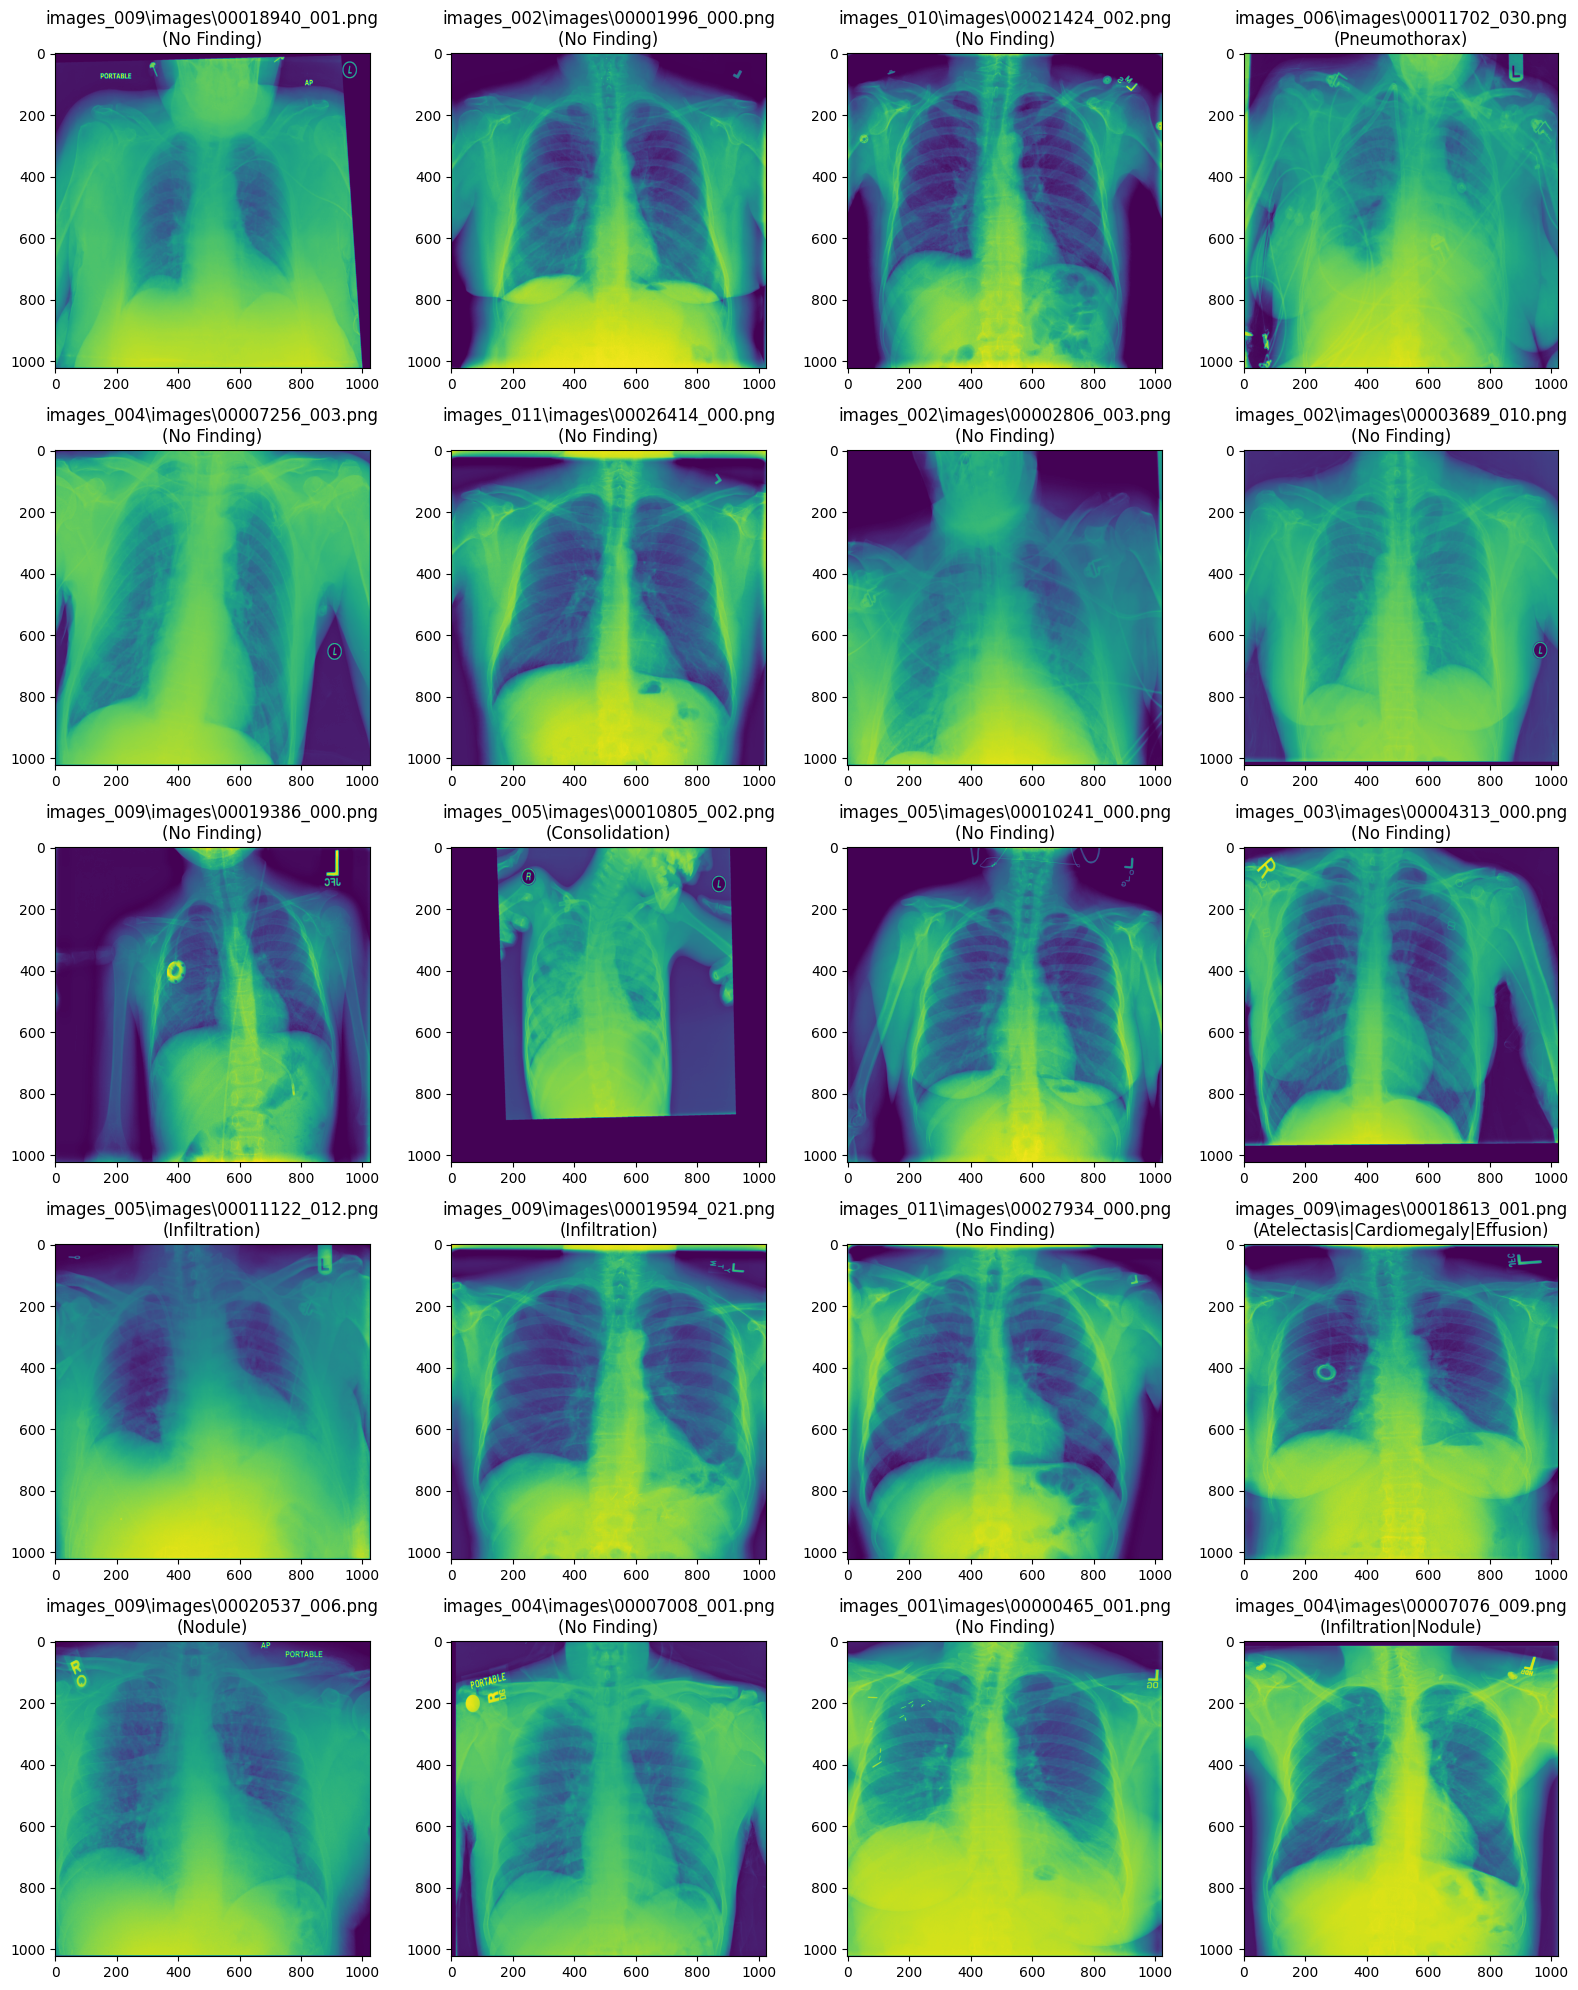

In [14]:
def plot_imgs_from_df(df, filepath_col, y_col, figsize=(16, 20), n_images=20, subplotshape=(5, 4)):
    # Plotting a sample of the original train images:
    plt.figure(figsize=figsize)
    for i in range(n_images):
        df_sample = df.sample()
        filepath = df_sample[filepath_col].values[0]
        image = Image.open(filepath)

        # show the image
        plt.subplot(subplotshape[0], subplotshape[1], i+1)
        plt.title(f"{filepath.split('/')[-1]}\n({df_sample[y_col].values[0]})")
        plt.imshow(image)

    plt.tight_layout()
    plt.show()
    
plot_imgs_from_df(data, filepath_col='img_filepath', y_col='Finding Labels')

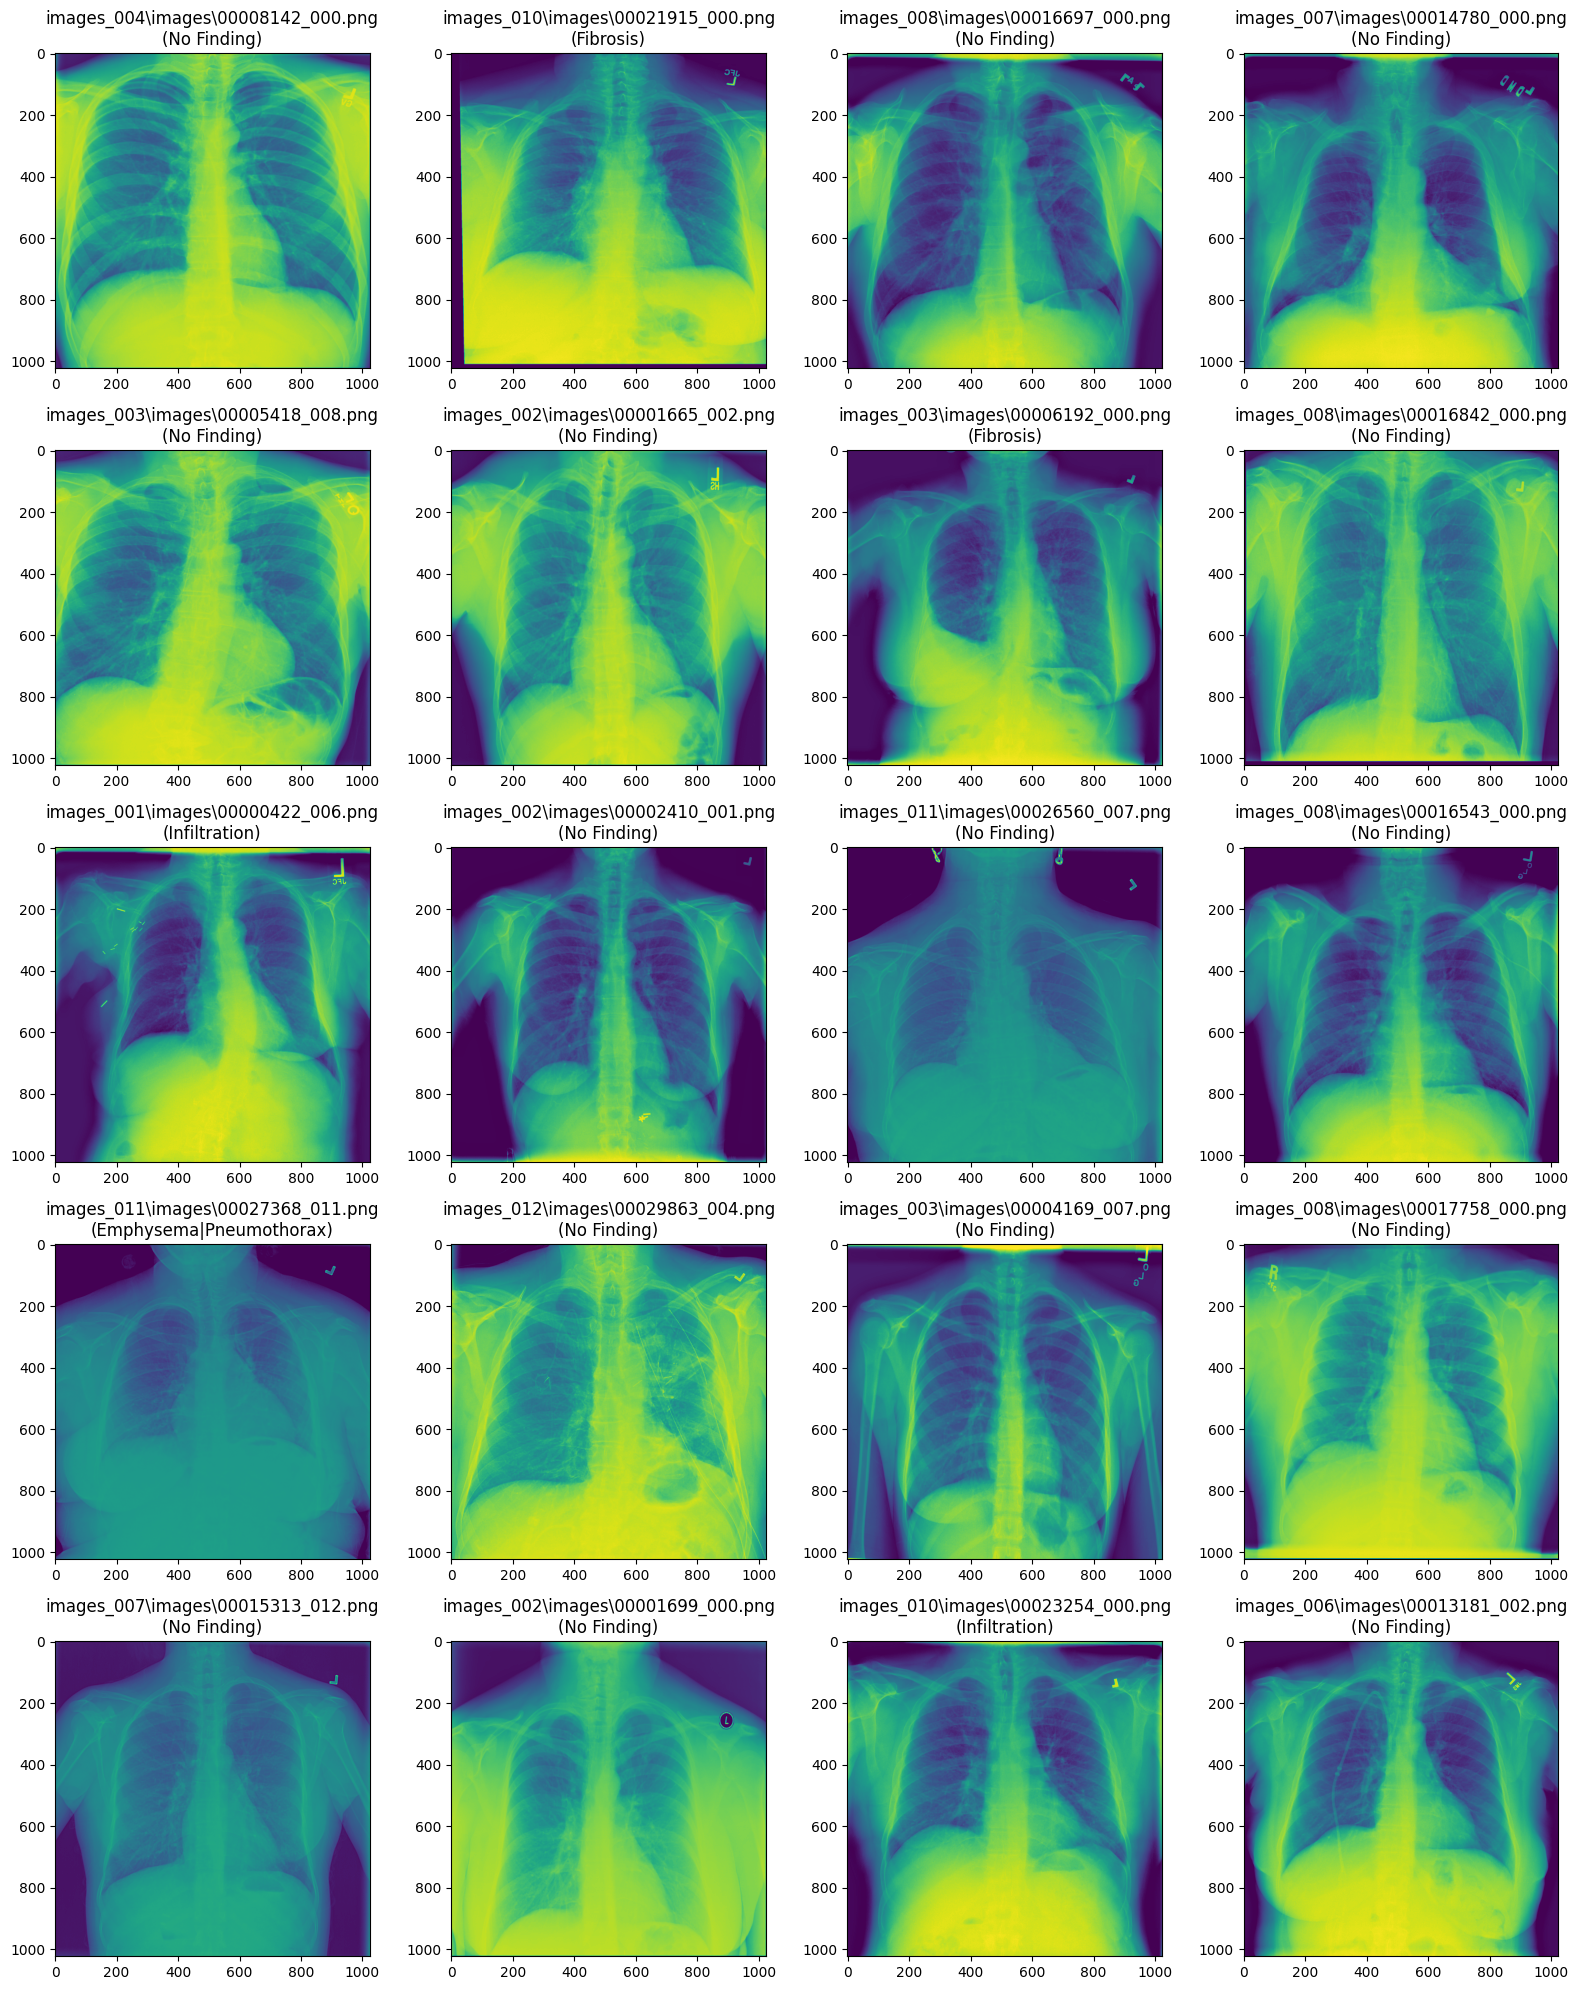

In [16]:
plot_imgs_from_df(data[data['View Position'] == 'PA'], filepath_col='img_filepath', y_col='Finding Labels')

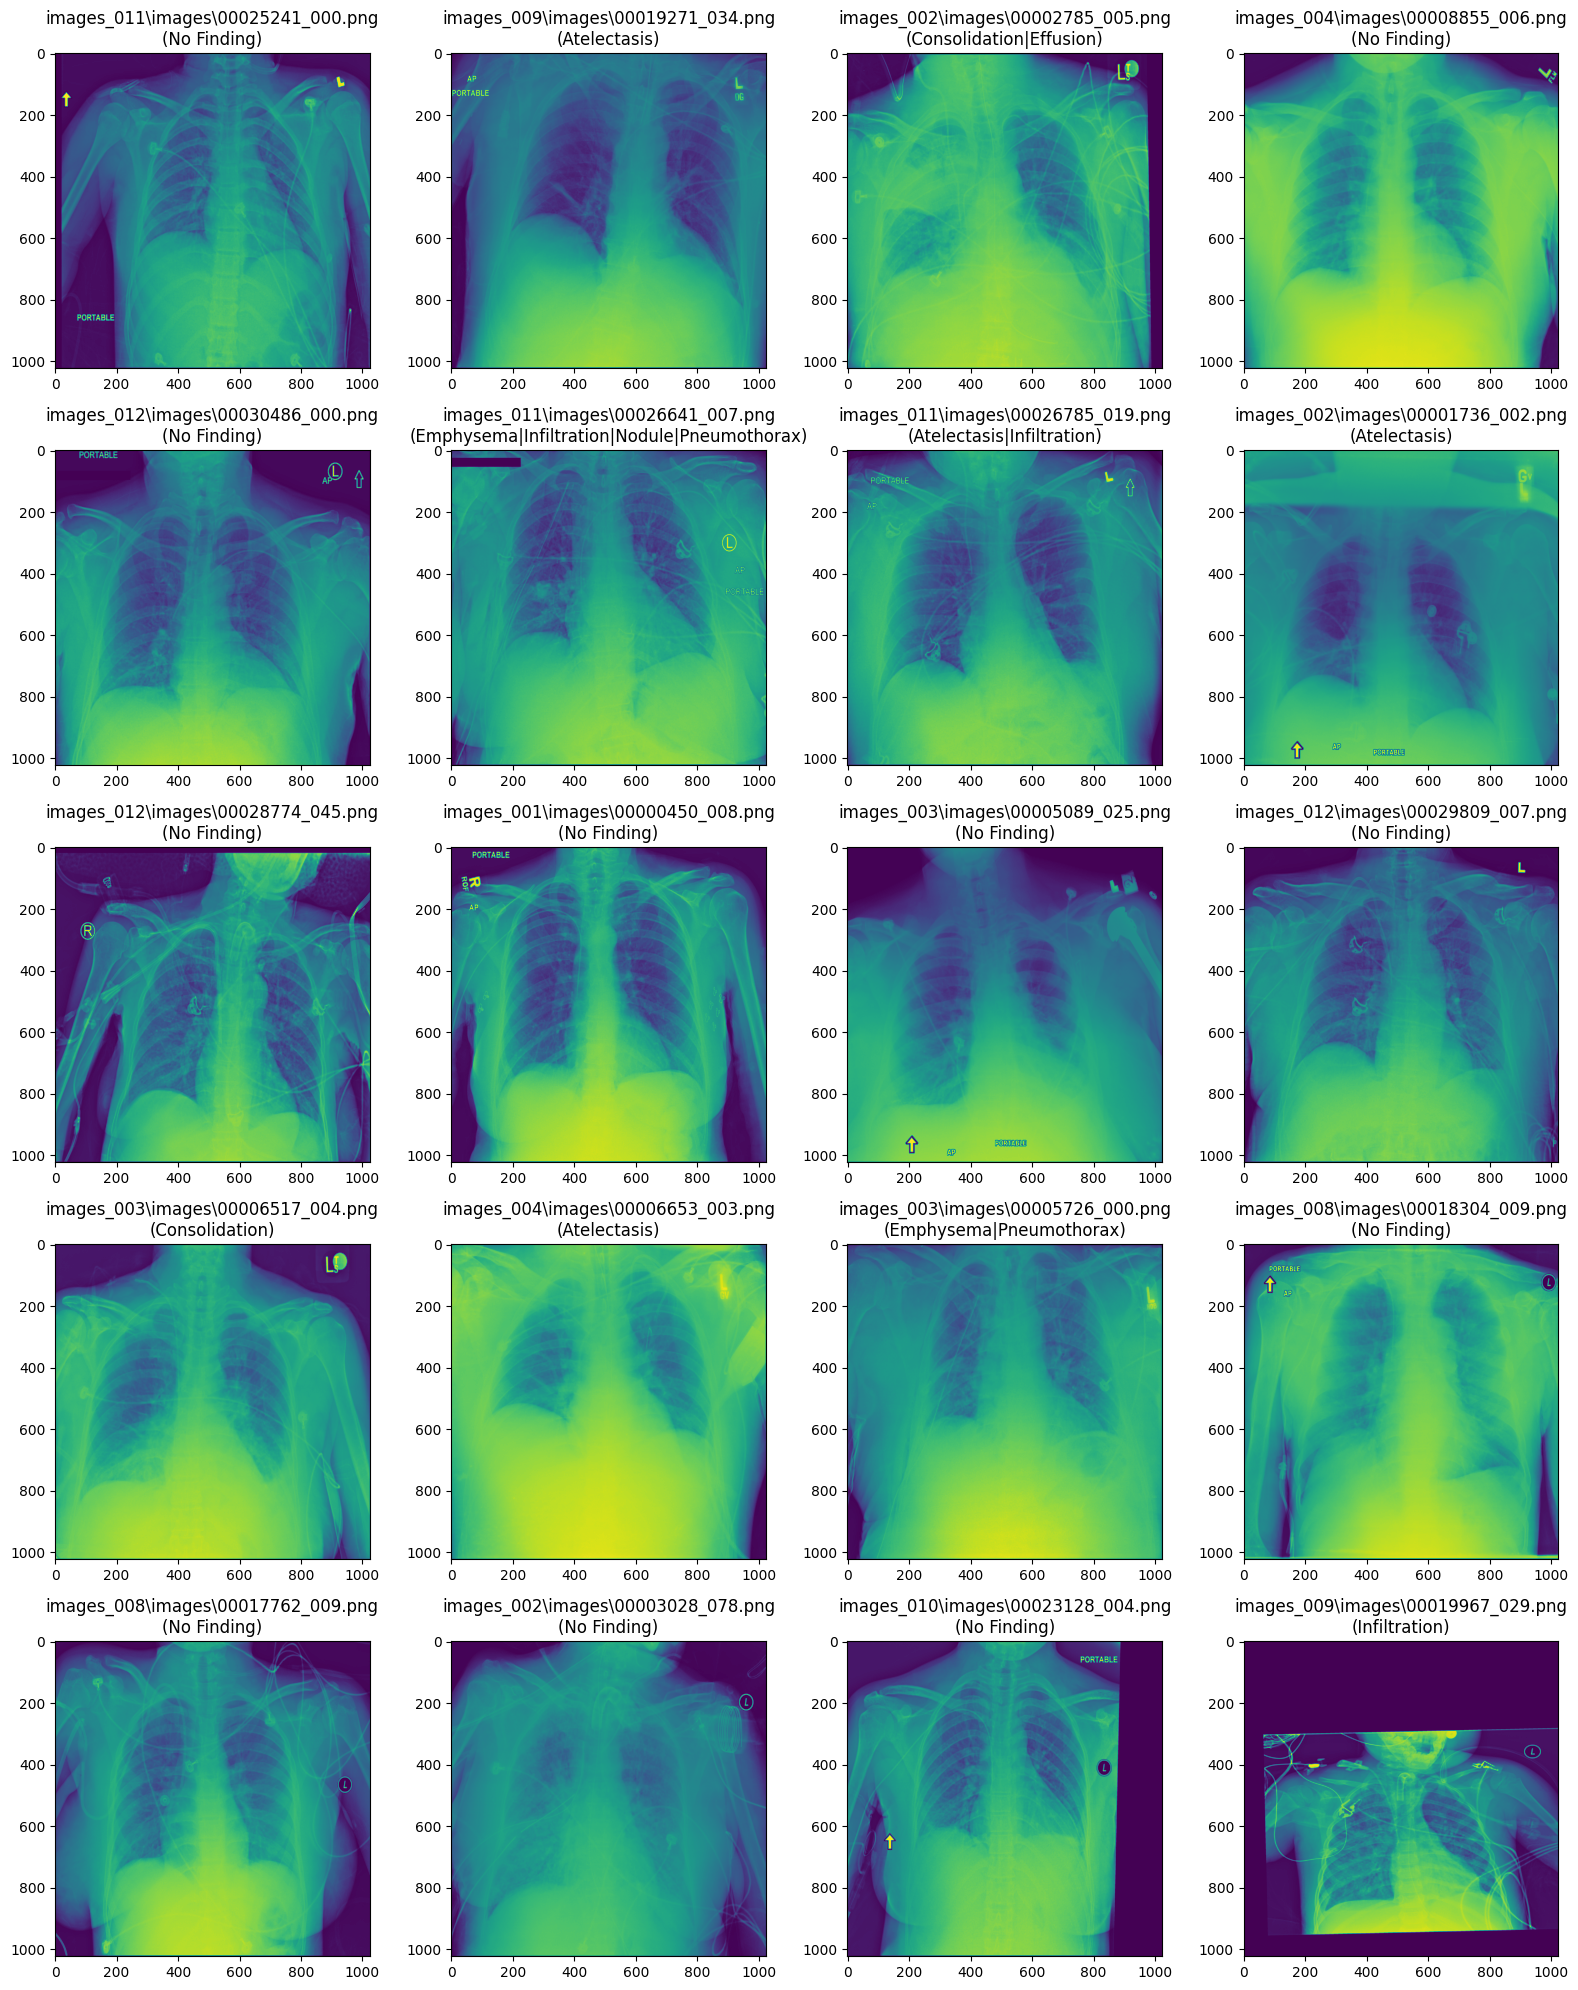

In [17]:
plot_imgs_from_df(data[data['View Position'] == 'AP'], filepath_col='img_filepath', y_col='Finding Labels')

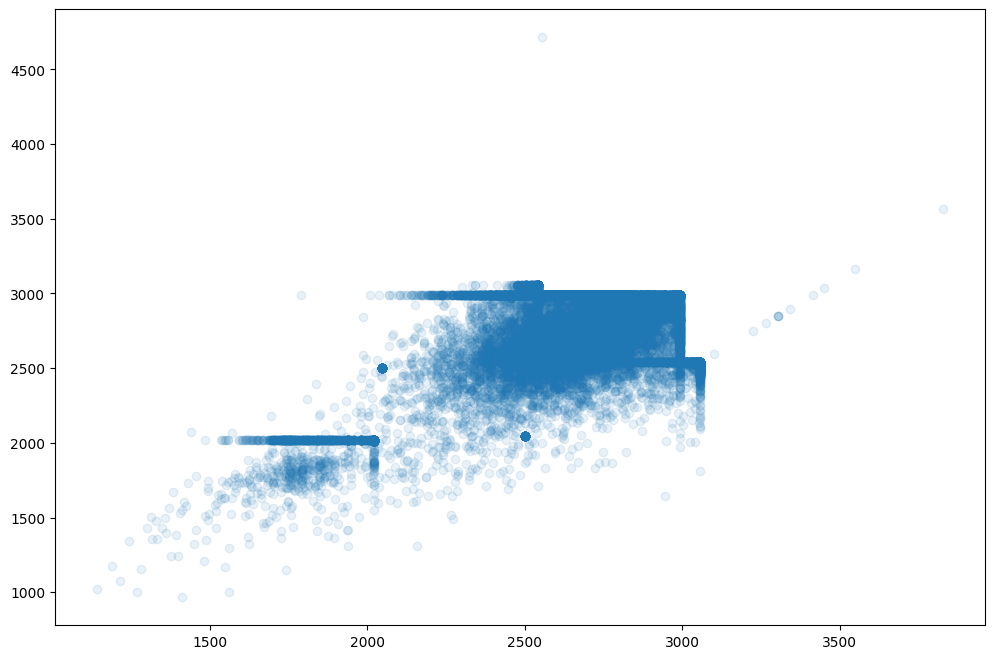

In [20]:
# Image size:
plt.figure(figsize=(12, 8))
plt.scatter(data['OriginalImage[Width'], data['Height]'], alpha=0.1)
plt.show()

### Conclusions

- Base de dados com imagens de diversos tamanhos.
- Total: 112120 imagens rotuladas
- Não cita a existência de diferentes protocolos para a geração das imagens, assumirei que todas seguem o mesmo protocolo.
- Há imagens com diferentes pontos de vista: 67310 PA e 44810 AP